In [47]:
import os
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import contextily as cx

In [2]:
# loading python packages and files from repo root
if Path(os.getcwd()).name != "SSL4EO_base":
    os.chdir("..")
from data import constants
from data.constants import MMEARTH_DIR, input_size
from data import MMEarthDataset, create_MMEearth_args

/work/project/cenv/ssl4eo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [145]:
# initialize dataset
modalities = { # only want positional information this time
    "lat": constants.MODALITIES_FULL["lat"], "lon": constants.MODALITIES_FULL["lon"]
}
split = "train"
args = create_MMEearth_args(MMEARTH_DIR, modalities, None)

dataset = MMEarthDataset(args, split=split)

In [146]:
# this contains all relevant information for us
tile_info = dataset.tile_info
tile_info_keys = list(tile_info.keys())

In [147]:
# our favourite crs
crs = "epsg:4326"

In [154]:
def get_location(idx):
    key = tile_info_keys[idx]
    tile_value = tile_info[key]
    
    # return point object
    return gpd.GeoDataFrame(
        geometry=[Point(tile_value["lon"], tile_value["lat"])], 
        crs=crs,#tile_value["CRS"] # local crs
    )#.to_crs(crs) # global crs

In [155]:
# lets get the first few point locations
num_samples = 100
gdf_list = [get_location(idx) for idx in range(num_samples)]

In [156]:
# Concatenate GeoDataFrames
gdf = pd.concat(gdf_list)

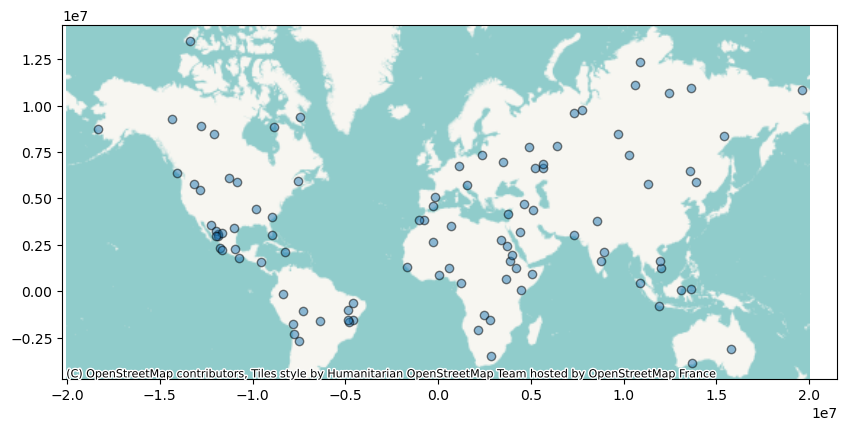

In [157]:
# plot and add basemap
plotting_crs = "EPSG:3857"
ax = gdf.to_crs(plotting_crs).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, crs=plotting_crs)

### Reverting the encoded positions

In [160]:
def get_location_encoded(idx):
    # lat lon are encoded with sin cos, so we need to reverse that encoding
    sin_lat, cos_lat = dataset[idx]["lat"]
    sin_lon, cos_lon = dataset[idx]["lon"]
    
    latitude = np.rad2deg(np.arctan2(sin_lat, cos_lat))
    longitude = np.rad2deg(np.arctan2(sin_lon, cos_lon))
    
    # return point object
    return Point(longitude, latitude)

# lets get the first few point locations
geometries = [get_location_encoded(idx) for idx in range(num_samples)]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs) # global crs

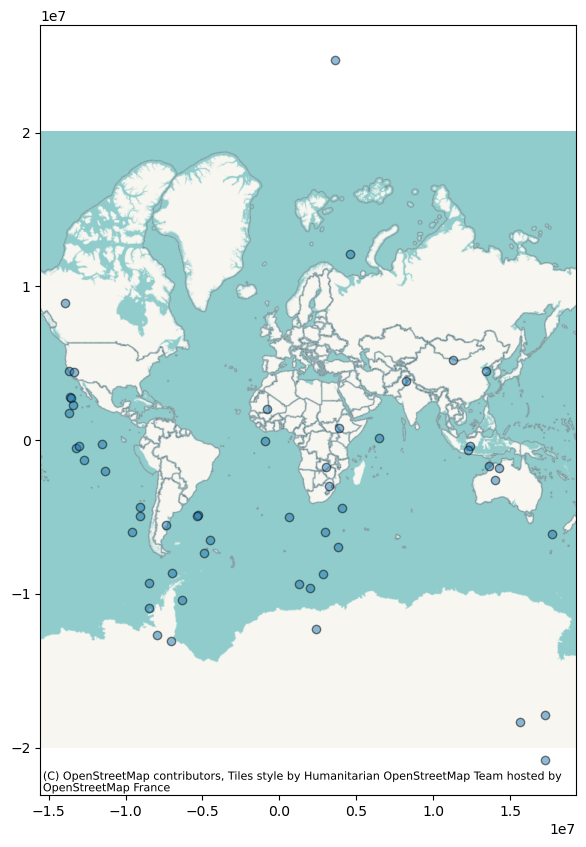

In [161]:
# plot and add basemap
plotting_crs = "EPSG:3857"
ax = gdf.to_crs(plotting_crs).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
cx.add_basemap(ax, crs=plotting_crs)